## SOFI 2D Model Builder - v2016 Script
### Beta version
- This code shows an interactive and step-by-step code to generate 2D models ready to run in SOFI2D
- It works only with 2016 version (json file cannot be read by v2023)
- Structures and examples are focused on acoustic well-logging applications
- Code stability: Design and QC tested and working for elastic models. QC for viscoelastic models is ongoing work.

##### Reference:
I used - SOFI 2D - User Guide written by Thomas Bohlen, Denise De Nil, Daniel Kohn and Stefan Jetschny

Link: https://git.scc.kit.edu/GPIAG-Software/SOFI2D/-/wikis/home


#### Imported Libraries

In [1]:
import os                                                 # to set current working directory 
import math                                               # basic calculations like square root
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames for tabular data
import matplotlib.pyplot as plt                           # plotting
import json
import struct
import sympy
from scipy.fft import fft, fftfreq, fftshift

#### Imported datafames

In [2]:
TaylorCoeffs=pd.read_csv('Taylor.csv',delimiter=',',index_col=0)
Holberg01Coeffs=pd.read_csv('Holberg_01.csv',delimiter=',',index_col=0)
Holberg03Coeffs=pd.read_csv('Holberg_03.csv',delimiter=',',index_col=0)
Holberg10Coeffs=pd.read_csv('Holberg_10.csv',delimiter=',',index_col=0)
Holberg30Coeffs=pd.read_csv('Holberg_30.csv',delimiter=',',index_col=0)

#### Functions - Model Generation (Long section, soon I may build a repository...)

In [3]:
# Layer placement libraries (Needs performance improvement)

# Horizontal layers
# Base Layer Generation Function
def HorizontalLayer(NX,NY,dh,zz_base,Top,Thickness,zz_new):
    xx_grid, yy_grid = np.meshgrid(np.linspace(0,NX-1,NX),np.linspace(0,NY-1,NY))
    xx_m=xx_grid*dh
    yy_m=yy_grid*dh
    for x in range(NY):
        for y in range(NX):
            if yy_m[x,y]>=Top and yy_m[x,y]<=(Top+Thickness):
                zz_base[y,x]=zz_new
    return zz_base

# Viscoelastic
def Placement_HorizontalLayer_Visco(zz_Vp,zz_Vs,zz_Rho,zz_Qp,zz_Qs,NX,NY,dh,Top,Thickness,Vp,Vs,Rho,Qp,Qs):
    zz_Vp=HorizontalLayer(NX,NY,dh,zz_Vp,Top,Thickness,Vp)
    zz_Vs=HorizontalLayer(NX,NY,dh,zz_Vs,Top,Thickness,Vs)
    zz_Rho=HorizontalLayer(NX,NY,dh,zz_Rho,Top,Thickness,Rho)
    zz_Qp=HorizontalLayer(NX,NY,dh,zz_Qp,Top,Thickness,Qp)
    zz_Qs=HorizontalLayer(NX,NY,dh,zz_Qs,Top,Thickness,Qs)
    return zz_Vp, zz_Vs, zz_Rho, zz_Qp, zz_Qs

# Elastic
def Placement_HorizontalLayer_Elastic(zz_Vp,zz_Vs,zz_Rho,NX,NY,dh,Top,Thickness,Vp,Vs,Rho):
    xx_grid, yy_grid = np.meshgrid(np.linspace(0,NX-1,NX),np.linspace(0,NY-1,NY))
    xx_m=xx_grid*dh
    yy_m=yy_grid*dh
    for x in range(NY):
        for y in range(NX):
            if yy_m[x,y]>=Top and yy_m[x,y]<=(Top+Thickness):
                zz_Vp[y,x]=Vp
                zz_Vs[y,x]=Vs
                zz_Rho[y,x]=Rho
    return zz_Vp, zz_Vs, zz_Rho

# Horizontal layers
# Base Layer Generation Function
def VerticalLayer(NX,NY,dh,zz_base,From,To,zz_new):
    xx_grid, yy_grid = np.meshgrid(np.linspace(0,NX-1,NX),np.linspace(0,NY-1,NY))
    xx_m=xx_grid*dh
    yy_m=yy_grid*dh
    for x in range(NY):
        for y in range(NX):
            if xx_m[x,y]>=From and xx_m[x,y]<=(To):
                zz_base[y,x]=zz_new
    return zz_base

# Viscoelastic
def Placement_VerticallLayer_Visco(zz_Vp,zz_Vs,zz_Rho,zz_Qp,zz_Qs,NX,NY,dh,From,To,Vp,Vs,Rho,Qp,Qs):
    zz_Vp=VerticalLayer(NX,NY,dh,zz_Vp,From,To,Vp)
    zz_Vs=VerticalLayer(NX,NY,dh,zz_Vs,From,To,Vs)
    zz_Rho=VerticalLayer(NX,NY,dh,zz_Rho,From,To,Rho)
    zz_Qp=VerticalLayer(NX,NY,dh,zz_Qp,From,To,Qp)
    zz_Qs=VerticalLayer(NX,NY,dh,zz_Qs,From,To,Qs)
    return zz_Vp, zz_Vs, zz_Rho, zz_Qp, zz_Qs

# Elastic
def Placement_VerticallLayer_Elastic(zz_Vp,zz_Vs,zz_Rho,NX,NY,dh,From,To,Vp,Vs,Rho):
    zz_Vp=VerticalLayer(NX,NY,dh,zz_Vp,From,To,Vp)
    zz_Vs=VerticalLayer(NX,NY,dh,zz_Vs,From,To,Vs)
    zz_Rho=VerticalLayer(NX,NY,dh,zz_Rho,From,To,Rho)
    return zz_Vp, zz_Vs, zz_Rho

# Dipping layers
# Rotation script
# Source:
# https://gist.github.com/LyleScott/e36e08bfb23b1f87af68c9051f985302#:~:text=Rotate%20X%2CY%20%282D%29%20coordinates%20around%20a%20point%20or,0%29.%22%22%22.%20%22%22%22Rotate%20a%20point%20around%20a%20given%20point.
def rotate_around_point_highperf(xy, radians, origin=(0, 0)):
    """Rotate a point around a given point.
    
    I call this the "high performance" version since we're caching some
    values that are needed >1 time. It's less readable than the previous
    function but it's faster.
    """
    x, y = xy
    offset_x, offset_y = origin
    adjusted_x = (x - offset_x)
    adjusted_y = (y - offset_y)
    cos_rad = math.cos(radians)
    sin_rad = math.sin(radians)
    qx = offset_x + cos_rad * adjusted_x + sin_rad * adjusted_y
    qy = offset_y + -sin_rad * adjusted_x + cos_rad * adjusted_y

    return qx, qy

# Base layer generation function
def DippingLayer(NX,NY,dh,zz_base,Top,Top_x_reference,Angle_deg,Thickness,zz_new):
    xx_grid, yy_grid = np.meshgrid(np.linspace(0,NX-1,NX),np.linspace(0,NY-1,NY))
    xx_m=xx_grid*dh
    yy_m=yy_grid*dh
    for x in range(NY):
        for y in range(NX):
            xy=(xx_m[x,y],yy_m[x,y])
            origin=(Top_x_reference,Top)
            radians=Angle_deg*math.pi/180
            [xx_m[x,y],yy_m[x,y]]=rotate_around_point_highperf(xy, radians, origin)
            if yy_m[x,y]>=Top and yy_m[x,y]<=(Top+Thickness):
                zz_base[y,x]=zz_new
    return zz_base

# Viscoelastic
def Placement_DippingLayer_Visco(zz_Vp,zz_Vs,zz_Rho,zz_Qp,zz_Qs,NX,NY,dh,Top,Top_x_reference,Angle_deg,Thickness,Vp,Vs,Rho,Qp,Qs):
    zz_Vp=DippingLayer(NX,NY,dh,zz_Vp,Top,Top_x_reference,Angle_deg,Thickness,Vp)
    zz_Vs=DippingLayer(NX,NY,dh,zz_Vs,Top,Top_x_reference,Angle_deg,Thickness,Vs)
    zz_Rho=DippingLayer(NX,NY,dh,zz_Rho,Top,Top_x_reference,Angle_deg,Thickness,Rho)
    zz_Qp=DippingLayer(NX,NY,dh,zz_Qp,Top,Top_x_reference,Angle_deg,Thickness,Qp)
    zz_Qs=DippingLayer(NX,NY,dh,zz_Qs,Top,Top_x_reference,Angle_deg,Thickness,Qs)
    return zz_Vp, zz_Vs, zz_Rho, zz_Qp, zz_Qs

# Elastic
def Placement_DippingLayer_Elastic(zz_Vp,zz_Vs,zz_Rho,NX,NY,dh,Top,Top_x_reference,Angle_deg,Thickness,Vp,Vs,Rho):
    zz_Vp=DippingLayer(NX,NY,dh,zz_Vp,Top,Top_x_reference,Angle_deg,Thickness,Vp)
    zz_Vs=DippingLayer(NX,NY,dh,zz_Vs,Top,Top_x_reference,Angle_deg,Thickness,Vs)
    zz_Rho=DippingLayer(NX,NY,dh,zz_Rho,Top,Top_x_reference,Angle_deg,Thickness,Rho)
    return zz_Vp, zz_Vs, zz_Rho
         

#### Functions - Saving/Loading files
References used binary-float32 data transformations:
https://docs.python.org/3/library/struct.html#examples
https://www.stackvidhya.com/python-read-binary-file/
https://pythonguides.com/python-read-a-binary-file/
https://www.bestprog.net/en/2020/04/30/python-binary-files-examples-of-working-with-binary-files/#:~:text=Python%20has%20tools%20for%20working%20with%20binary%20files.,function%2C%20whose%20mode%20parameter%20contains%20the%20character%20%E2%80%98b%E2%80%99

In [4]:
def openfile_frombinarytofloat32array(filename,nx_file,ny_file):
    newfile=open(filename,"rb")
    filecontent=newfile.readline()
    datasize=struct.calcsize('f')
    contentsize=len(filecontent)/datasize
    if nx_file*ny_file==contentsize:
        print('File size is correct')
        data = np.zeros([nx_file,ny_file])
        count=0
        for n in range(nx_file):
            for m in range(ny_file):
                data[n,m] = struct.unpack('f',filecontent[count:count+4])[0]
                count=count+4
    else:
        data=[]
        print('File size is NOT correct')
        print(nx_file*ny_file)
        print(contentsize)
    return data

def savefile_fromfloat32arraytobinary(filename,nx_file,ny_file,array):
    newfile=open(filename,"wb")
    for n in range(nx_file):
        for m in range(ny_file):
            output_binary=struct.pack('f',array[n,m])
            newfile.write(output_binary)

#### Functions - Array Placement (Source and Receivers Placement)

In [5]:
def LinearArray(x_start,x_end,y_start,y_end,spacing):
    ArrayLength=np.sqrt((x_end-x_start)**2+(y_end-y_start)**2)
    if x_end==x_start:
        ArrayAngle=np.pi/2
    else:
        ArrayAngle=math.atan((y_end-y_start)/(x_end-x_start))
    ArraySize=int(ArrayLength/spacing)
    if ArraySize<=1:
        Array=np.zeros([1,2])
        Array[0,0]=x_start
        Array[0,1]=y_start
    else:
        Array=np.zeros([ArraySize,2])
        for n in range(ArraySize):
            Array[n,0]=x_start+n*spacing*np.cos(ArrayAngle)
            Array[n,1]=y_start+n*spacing*np.sin(ArrayAngle)
    return Array

def TRplacement(GridSize,Gridref_x,Gridref_y,Input):               #this function transforms a set of coordinates into an array of coordinates for source/receiver placement
    function_grid=np.zeros([len(Input),2])
    for n in range(len(Input)):                                     #transform from coordinate to grid points
        function_grid[n,0]=int((Input[n,0]-Gridref_x)/GridSize)
        function_grid[n,1]=int((Input[n,1]-Gridref_y)/GridSize)
    #Clean duplicate values
    temp=np.ones(np.shape(function_grid))*np.nan                   #Create a vector the same size as the input, this is the non-duplicate list
    temp[0,:]=function_grid[0,:]
    count=1
    index=0
    for n in range(len(function_grid)):                            #Take one by one the transformed values...
        flag=0
        for m in range(count):                                     #...and compare them against the non-duplicate list
            if flag==0:
                if function_grid[n,0]==temp[m,0] and function_grid[n,1]==temp[m,1]:
                    flag=1
        if flag==0:                                                #if an 'n' value wasnt found in the non-duplicate vector list...
            count=count+1                                          #...then it is added as a new component
            temp[count-1,:]=function_grid[n,:]
    function_gridded=temp[0:count,:]                               #we uppdate the size of the output to the total of non-duplicated values
    function_gridded_m=function_gridded*0
    for n in range(len(function_gridded_m)):
        function_gridded_m[n,0]=(function_gridded[n,0]*GridSize+Gridref_x)
        function_gridded_m[n,1]=(function_gridded[n,1]*GridSize+Gridref_y)    
    return function_gridded_m

def TRcornercleaning(function_gridded):                            #this function cleans up corners generated by the TRPlacement function
    temp=np.ones(np.shape(function_gridded))*np.nan
    temp[0,:]=function_gridded[0,:]
    count=1
    for n in range(1,len(function_gridded)-1):
        if function_gridded[n,0]==function_gridded[n-1,0] and function_gridded[n,1]==function_gridded[n+1,1]:
            count=count
        else:
            count=count+1
            temp[count-1,:]=function_gridded[n,:]
    temp[count,:]=function_gridded[len(function_gridded)-1,:]
    function_gridded_clean=temp[0:count+1,:]
    return function_gridded_clean

# For reflection
def SourceArray_Angle(ref_x,ref_y,radius,angle,length,spacing):
    center_x=ref_x+np.cos(np.pi/180*angle)*radius
    center_y=ref_y+np.sin(np.pi/180*angle)*radius
    x_start=center_x-np.cos(np.pi/180*angle)*length/2
    y_start=center_y-np.sin(np.pi/180*angle)*length/2
    x_end=center_x+np.cos(np.pi/180*angle)*length/2
    y_end=center_y+np.sin(np.pi/180*angle)*length/2
    Array_raw=LinearArray(x_start,x_end,y_start,y_end,spacing)
    return Array_raw
def ReceiverArray_Angle(ref_x,ref_y,radius,angle,length,spacing):
    center_x=ref_x-np.cos(np.pi/180*angle)*radius
    center_y=ref_y+np.sin(np.pi/180*angle)*radius
    x_start=center_x-np.cos(np.pi/180*angle)*length/2
    y_start=center_y+np.sin(np.pi/180*angle)*length/2
    x_end=center_x+np.cos(np.pi/180*angle)*length/2
    y_end=center_y-np.sin(np.pi/180*angle)*length/2
    Array_raw=LinearArray(x_start,x_end,y_start,y_end,spacing)
    return Array_raw
def ReceiverArrayOpposite_Angle(ref_x,ref_y,radius,angle,length,spacing):
    center_x=ref_x-np.cos(np.pi/180*angle)*radius
    center_y=ref_y-np.sin(np.pi/180*angle)*radius
    x_start=center_x-np.cos(np.pi/180*angle)*length/2
    y_start=center_y-np.sin(np.pi/180*angle)*length/2
    x_end=center_x+np.cos(np.pi/180*angle)*length/2
    y_end=center_y+np.sin(np.pi/180*angle)*length/2
    Array_raw=LinearArray(x_start,x_end,y_start,y_end,spacing)
    return Array_raw

# Legacy
def SRPlacement(dh_model,x_start,x_end,y_start,y_end):
    xgrid_start=int(np.round(x_start/dh_model))
    xgrid_end=int(np.round(x_end/dh_model))
    ygrid_start=int(np.round(y_start/dh_model))
    ygrid_end=int(np.round(y_end/dh_model))
    if xgrid_end-xgrid_start==0:
        if ygrid_end-ygrid_start==0:
            XSRC_grid=xgrid_start
            YSRC_grid=ygrid_start
        else:
            XSRC_grid=np.ones(ygrid_end-ygrid_start)*xgrid_start
            YSRC_grid=np.arange(ygrid_start,ygrid_end,1)
    else:
        if ygrid_end-ygrid_start==0:
            YSRC_grid=np.ones(xgrid_end-xgrid_start)*ygrid_start
            XSRC_grid=np.arange(xgrid_start,xgrid_end,1)
        else:
            b=(ygrid_end-ygrid_start)/(xgrid_end-xgrid_start)
            a=ygrid_start-b*xgrid_start
            if xgrid_end-xgrid_start>ygrid_end-ygrid_start:
                YSRC_grid=np.ones(xgrid_end-xgrid_start)
                XSRC_grid=np.arange(xgrid_start,xgrid_end,1)
                for n in range(len(YSRC_grid)):
                    YSRC_grid[n]=int(round(a+b*XSRC_grid[n]))
            else:
                XSRC_grid=np.ones(ygrid_end-ygrid_start)
                YSRC_grid=np.arange(ygrid_start,ygrid_end,1)
                for n in range(len(YSRC_grid)):
                    XSRC_grid[n]=int(round((YSRC_grid[n]-a)/b))
    return XSRC_grid, YSRC_grid

#### Functions - Plots

In [6]:
# Plotting libraries
def plotmodels_elastic(xx_grid,yy_grid,zz_Vp,zz_Vs,zz_Rho):
    plt.subplot(1,3,1)
    im1 = plt.contourf(xx_grid, yy_grid, zz_Vp,500,cmap=plt.cm.jet,norm=None)
    plt.title('P-wave model')
    plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
    cbar = plt.colorbar(im1, orientation = 'vertical')
    cbar.set_label("P-wave velocity (m/s)")

    plt.subplot(1,3,2)
    im2 = plt.contourf(xx_grid, yy_grid, zz_Vs,500,cmap=plt.cm.jet,norm=None)
    plt.title('S-wave model')
    plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
    cbar = plt.colorbar(im2, orientation = 'vertical')
    cbar.set_label("S-wave velocity (m/s)")

    plt.subplot(1,3,3)
    im3 = plt.contourf(xx_grid, yy_grid, zz_Rho,500,cmap=plt.cm.jet,norm=None)
    plt.title('Density model')
    plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
    cbar = plt.colorbar(im3, orientation = 'vertical')
    cbar.set_label("Density (kg/m^3)")

    plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=2, wspace=0.2, hspace=0.2)
    
def plotmodels_visco(xx_grid,yy_grid,zz_Vp,zz_Vs,zz_Rho,zz_Qp,zz_Qs):
    plt.subplot(2,3,1)
    im1 = plt.contourf(xx_grid, yy_grid, zz_Vp,500,cmap=plt.cm.jet,norm=None)
    plt.title('P-wave model')
    plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
    cbar = plt.colorbar(im1, orientation = 'vertical')
    cbar.set_label("P-wave velocity (m/s)")

    plt.subplot(2,3,2)
    im2 = plt.contourf(xx_grid, yy_grid, zz_Vs,500,cmap=plt.cm.jet,norm=None)
    plt.title('S-wave model')
    plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
    cbar = plt.colorbar(im2, orientation = 'vertical')
    cbar.set_label("S-wave velocity (m/s)")

    plt.subplot(2,3,3)
    im3 = plt.contourf(xx_grid, yy_grid, zz_Rho,500,cmap=plt.cm.jet,norm=None)
    plt.title('Density model')
    plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
    cbar = plt.colorbar(im3, orientation = 'vertical')
    cbar.set_label("Density (kg/m^3)")

    plt.subplot(2,3,4)
    im4 = plt.contourf(xx_grid, yy_grid, zz_Qp,500,cmap=plt.cm.jet,norm=None)
    plt.title('P-wave attenuation model')
    plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
    cbar = plt.colorbar(im4, orientation = 'vertical')
    cbar.set_label("P-wave attenuation")

    plt.subplot(2,3,5)
    im5 = plt.contourf(xx_grid, yy_grid, zz_Qs,500,cmap=plt.cm.jet,norm=None)
    plt.title('S-wave attenuation model')
    plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
    cbar = plt.colorbar(im5, orientation = 'vertical')
    cbar.set_label("S-wave attenuation")

    plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3, wspace=0.2, hspace=0.2)

#### Functions - Other Functions

In [7]:
def MEM_Allocation_Estimate(NX,NY,TIME,DT,FDORDER,FDORDER_TIME,L,SEISMO,nreceivers,NDT,ABS_TYPE,FW,sizeofMPIFloat):
    # Calculating total time steps
    TSteps=int(np.round(TIME/DT))
    # Model Order
    nd=FDORDER/2
    fdo3=2*nd
    fac1=(NX+fdo3)*(NY+fdo3)
    fac2 = np.finfo(np.float32).eps * pow(2.0, -20.0)
    # Checking viscoelastic model (and Time Order)
    if FDORDER_TIME==2:
        memadd=0
        memadd_L=0
    elif FDORDER_TIME==4:
        memadd=24
        memadd_L=9
    if L>0:
        memdyn = ( memadd+ 5.0 + (3.0+memadd_L) * L ) * fac1 * fac2
        memmodel = ( 12.0 + 3.0 * L ) * fac1 * fac2 + NX * NY * fac2
    else:
        memdyn = (memadd+5.0) * fac1 * fac2
        memmodel = 6.0 * fac1 * fac2 + NX * NY * fac2
    # Memory from Seismograms
    ns=int(np.round(TSteps/NDT))
    if SEISMO==1:
        nseismograms=3
    if SEISMO==2:
        nseismograms=1
    if SEISMO==3:
        nseismograms=2
    if SEISMO==4:
        nseismograms=6
    memseismograms = nseismograms * nreceivers * ns * fac2
    # Buffer memory
    membuffer = 2.0 * fdo3 * ( NY + NX ) * fac2
    buffsize = 2.0 * 2.0 * fdo3 * ( NX + NY ) * sizeofMPIFloat
    # Memory for CMPL
    if ABS_TYPE==1:
        memcpml=2.0*FW*4.0* ( NY+NX ) *fac2+20.0*2.0*FW*fac2
    else:
        memcpml=0
    # Total Memory
    memtotal = memdyn + memmodel + memseismograms + membuffer +memcpml + ( buffsize * pow ( 2.0, -20.0 ) )
    MemoryArray=[memtotal, memdyn, memmodel, memseismograms,membuffer,buffsize,memcpml]
    return MemoryArray

### 1. Predefining the grid

#### 1.1 Grid Stability

Optimal grid dimensions definition for a stable grid requires preliminary knowledge of:
- Maximum and minimum velocities
- Maximum frequency
- X-Y Dimensions
- Modeling time span

We can use specific sets of Finite Difference (FD) model errors to ensure stability in space and time domain.

##### 1.1-a Unit and total grid size
First, we analize, based on expected frequencies and velocities the expected maximum unit grid size for all available FD model error and orders.
Error models are
- Taylor
- Holberg (0.1%)
- Holberg (0.3%)
- Holberg (1.0%)
- Holberg (3.0%)
Error orders have unique values: 2, 4, 6, 8, 10, 12

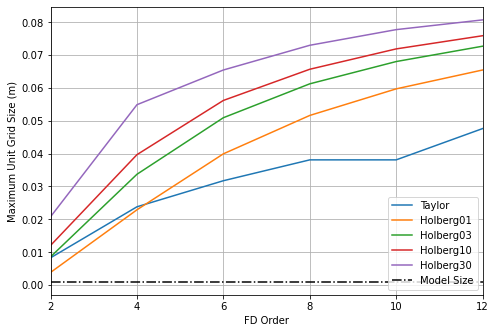

In [8]:
# Model Parameters
ModelMinVel=1524                    #[m/s] Expected minimum velocity
# Model Frequency
CenterFrequency=4000                     #[Hz] Expected center frequency
MaxFrequency=2*CenterFrequency         #[Hz] Expected max frequency
# Model Steps
Modelsize=0.001                                      # [m] unit grid size (DH parameter)

Model_dict={'Taylor':TaylorCoeffs,'Holberg01':Holberg01Coeffs,'Holberg03':Holberg03Coeffs,'Holberg10':Holberg10Coeffs,'Holberg30':Holberg30Coeffs}
Model_list=['Taylor','Holberg01','Holberg03','Holberg10','Holberg30']

dhstab=np.zeros((len(Model_list),len(Model_dict['Taylor'].index.values)))
for n, modelname in enumerate(Model_list):
    model=Model_dict[modelname]
    for m, fdorder in enumerate(model.index.values):
        unitgridsize=model[model.index==fdorder]['MinGridsperWavelength'].values[0]
        dhstab[n,m]=ModelMinVel/(unitgridsize*MaxFrequency)
    plt.plot(model.index.values,dhstab[n,:],label=modelname)
plt.plot([2,12],[Modelsize,Modelsize],'k',ls='-.',label='Model Size')
plt.legend()
plt.grid()
plt.xlim(2,12)
plt.xlabel('FD Order')
plt.ylabel('Maximum Unit Grid Size (m)')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1.0, wspace=0.2, hspace=0.2)

##### 1.1-a Time step

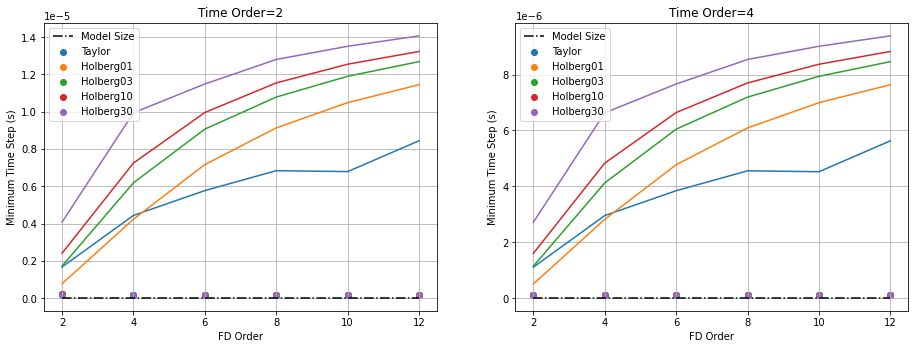

In [9]:
# Model Parameters:
# Model Size:

# Model Velocities:
ModelMaxVel=3500                    #[m/s] Expected maximum velocity 
# Model Frequency
CenterFrequency=CenterFrequency                     #[Hz] Expected center frequency
MaxFrequency=2*CenterFrequency         #[Hz] Expected max frequency
# Model Steps
Modelsize=Modelsize                                      # [m] unit grid size (DH parameter)
Modeltimestep=2.5e-8                                 # [s] unit step size (DT parameter)

timeorder=[2,4]
temporal=np.array([1,3/2])
dtstab=np.zeros((2,len(Model_list),len(Model_dict['Taylor'].index.values)))
dtstab_model=np.zeros((2,len(Model_list),len(Model_dict['Taylor'].index.values)))
for k in range(2):
    plt.subplot(1,2,k+1)
    for n, modelname in enumerate(Model_list):
        model=Model_dict[modelname]
        for m, fdorder in enumerate(model.index.values):
            size=dhstab[n,m]
            gamma=model[model.index==fdorder]['H1'].values[0]+model[model.index==fdorder]['H2'].values[0]+model[model.index==fdorder]['H3'].values[0]+model[model.index==fdorder]['H4'].values[0]+model[model.index==fdorder]['H5'].values[0]+model[model.index==fdorder]['H6'].values[0]
            dtstab[k,n,m]=size/(np.sqrt(2)*gamma*ModelMaxVel*temporal[k])
            dtstab_model[k,n,m]=Modelsize/(np.sqrt(2)*gamma*ModelMaxVel*temporal[k])
        plt.plot(model.index.values,dtstab[k,n,:])
        plt.scatter(model.index.values,dtstab_model[k,n,:],label=modelname)
    plt.plot([2,12],[Modeltimestep,Modeltimestep],'k',ls='-.',label='Model Size')
    plt.title('Time Order='+str(timeorder[k]))
    plt.legend()
    plt.grid()
    plt.xlabel('FD Order')
    plt.ylabel('Minimum Time Step (s)')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=1.0, wspace=0.2, hspace=0.2)

Model geometry
  Model frequency: 4.00E+03 Hz
  Expected velocities are: 1.52E+03 m/s (Min) and 3.50E+03 m/s (Max)
  Curren unit grid size is: 1.00E-03 m
  Model size is X direction: 3.00E-01 m and in Y direction: 7.00E+00 m
  Expected grid number in X direction: 300 and in Y direction: 7000
  Minimum required time step is: 2.50000E-08 s
  Expected time steps: 220000
  Expected output steps: 220000
Memory allocation estimation
   Dynamic variables:  3.2094E-07  MB
   Static variables:  7.6632E-08  MB
   Seismograms:  7.5033E-07  MB
   Buffer arrays for grid exchange:  1.6371E-09  MB
   Network Buffer for MPI_Bsend:  1.0986E-01  MB
   CPML variables:  5.5024E-09  MB
 Total memory required:  1.0986E-01  MB


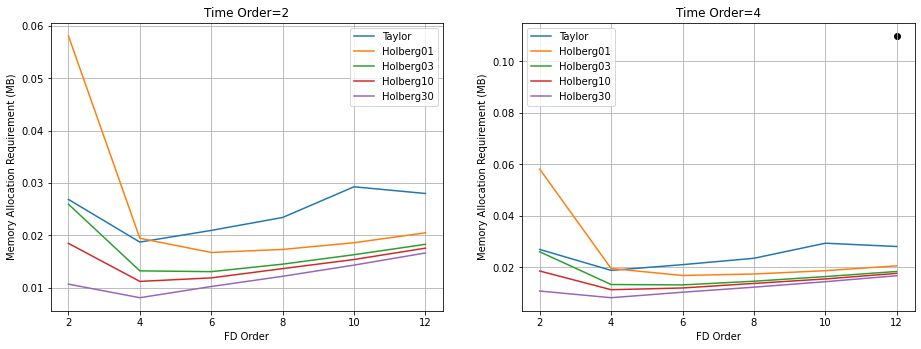

In [10]:
#Parameters
# Model Size:
X_length=0.3                                     # [m] grid length along X-direction
Y_length=7                                     # [m] grid length along Y-direction
T_length=5.5/1000                                        # [s] simulation time (TIME parameter)
CenterFrequency=CenterFrequency                     #[Hz] Expected center frequency
# Model Steps
Modelsize=Modelsize                                      # [m] unit grid size (DH parameter)
Modeltimestep=Modeltimestep                                 # [s] unit step size (DT parameter)
# Preliminary error parameters
FDmodel=1                                         # [-] FD Error model (1: Taylor, 2: Holberg(0.1%), 3: Holberg(0.1%), 4: Holberg(0.1%), 5: Holberg(0.1%) - MAXRELERROR parameter)
FD_order=12                                        # [-] FD Error order (2, 4, 6, 8, 10, 12 - FDERROR parameter)
FD_ordertime=4                                    # [-] FD Time Error order (2, 4 - FDERROR_TIME parameter)
# Boundary Conditions
abstype=1                                         # [-] 1 if using a PML (ABS_TYPE parameter)
abswidth=10                                       # [-] number of grids used for boundary (FW parameter)
# Viscoelastic (Q-approximation)
L=0                                               # [-] number of viscoelastic modes (L parameter)
# Output data
outputtype=1                                      # [-] seismogram output (1:vxx,vyy,vxy; 2:p; 3:div,curl; 4:all - parameter SEISMO)
expected_recs=10                                  # [-] expected total receivers               
samplestepping=1                                  # [-] interval between time steps to sample data (NDT parameter)
# Others
sizeofMPIFloat=4                                  # [-] size of MPIfloat in bytes (assumed)

PreliminaryMEM = MEM_Allocation_Estimate(int(np.round(X_length/Modelsize)),int(np.round(X_length/Modelsize)),T_length,Modeltimestep,FD_order,FD_ordertime,L,outputtype,expected_recs,samplestepping,abstype,abswidth,sizeofMPIFloat)

memtotal=np.zeros((2,len(Model_list),len(Model_dict['Taylor'].index.values)))
for k in range(2):
    plt.subplot(1,2,k+1)
    if k==FD_ordertime/2-1:
        plt.scatter(FD_order,PreliminaryMEM[0],c='k')
    for n, modelname in enumerate(Model_list):
        model=Model_dict[modelname]
        for m, fdorder in enumerate(model.index.values):
            modelsize=dhstab[n,m]
            modeltimestep=dtstab_model[k,n,m]
            # Calculating total grid size in x and y direction
            TotalX=int(np.round(X_length/modelsize))
            TotalY=int(np.round(Y_length/modelsize))
            memtotal[k,n,m] = MEM_Allocation_Estimate(TotalX,TotalY,T_length,modeltimestep,fdorder,timeorder[k],L,outputtype,expected_recs,samplestepping,abstype,abswidth,sizeofMPIFloat)[0]
        plt.plot(model.index.values,memtotal[k,n,:],label=modelname)
#         plt.scatter(model.index.values,dtstab_model[k,n,:],label=modelname)
    plt.title('Time Order='+str(timeorder[k]))
    plt.legend()
    plt.grid()
    plt.xlabel('FD Order')
    plt.ylabel('Memory Allocation Requirement (MB)')

print('Model geometry')
print('  Model frequency: '+str('{:.2E}'.format(CenterFrequency))+' Hz')
print('  Expected velocities are: '+str('{:.2E}'.format(ModelMinVel))+' m/s (Min) and '+str('{:.2E}'.format(ModelMaxVel))+' m/s (Max)')
print('  Curren unit grid size is: '+str('{:.2E}'.format(Modelsize))+' m')
print('  Model size is X direction: '+str('{:.2E}'.format(X_length))+' m and in Y direction: '+str('{:.2E}'.format(Y_length))+' m')
print('  Expected grid number in X direction: '+str(int(np.round(X_length/Modelsize)))+' and in Y direction: '+str(int(np.round(Y_length/Modelsize))))
print('  Minimum required time step is: '+str('{:.5E}'.format(Modeltimestep))+' s')
print('  Expected time steps: '+str(int(np.round(T_length/Modeltimestep))))
print('  Expected output steps: '+str(int(np.round(T_length/Modeltimestep/samplestepping))))
print("Memory allocation estimation")
print("   Dynamic variables: ", str('{:.4E}'.format(PreliminaryMEM[1])), " MB")
print("   Static variables: ", str('{:.4E}'.format(PreliminaryMEM[2])), " MB")
print("   Seismograms: ", str('{:.4E}'.format(PreliminaryMEM[3])), " MB" )
print("   Buffer arrays for grid exchange: ", str('{:.4E}'.format(PreliminaryMEM[4])), " MB" )
print("   Network Buffer for MPI_Bsend: ", str('{:.4E}'.format(PreliminaryMEM[5] * pow ( 2.0, -20.0 )))," MB" );
if ( abstype==1 ):
    print("   CPML variables: ", str('{:.4E}'.format(PreliminaryMEM[6]))," MB" )
print(" Total memory required: ", str('{:.4E}'.format(PreliminaryMEM[0]))," MB" )

plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=1.0, wspace=0.2, hspace=0.2)

### 2. Defining the model
Once I generate the grid, I generate a base model using a single layer with the initial parametrical values: P-wave model, S-wave model, Density model, P-wave attenuation model and S-wave attenuation model.
- Each layer has a constant value for each parameter
- Every subsequent layer replaces the preexisting value of parameter within the layer grid
- Layer input is done through grid coordinates range and parameters

In [11]:
# Model allocation during generation
print('Preliminary values: DH = '+str(Modelsize)+' m, DT = '+str(Modeltimestep)+' s')
print('Preliminary dimensions: NX = '+str(int(np.round(X_length/Modelsize)))+' grid points, NY = '+str(int(np.round(Y_length/Modelsize)))+' grid points')
print('Preliminary time length TIME = '+str(T_length)+' s')

Preliminary values: DH = 0.001 m, DT = 2.5e-08 s
Preliminary dimensions: NX = 300 grid points, NY = 7000 grid points
Preliminary time length TIME = 0.0055 s


##### Notes before choosing NX, NY
- Try to use NX and NY with multiple prime factors to improve flexibility on parametrization
- Other parameters related to NX, NY values are:
    - NPROCX, NPROCY

In [12]:
# Model parameters
DH=0.001                    #[m]
DT=2.5e-8                   #[s]
NX=300                      #[-]
NY=7000                     #[-]
TIME=0.0055                 #[s]

print('Model dimensions: X = '+str(NX*DH)+' m, Y = '+str(NY*DH)+' m')
print('Model will require a total of '+str(int(TIME/DT))+' time steps')

Model dimensions: X = 0.3 m, Y = 7.0 m
Model will require a total of 220000 time steps


In [13]:
print('Prime factors for NX: '+ str(sympy.primefactors(NX)))
print('Prime factors for NY: '+ str(sympy.primefactors(NY)))

Prime factors for NX: [2, 3, 5]
Prime factors for NY: [2, 5, 7]


In [14]:
# Memory allocation
# Is model elastic or viscoelastic?
L=0                              # [-] number of modes (= 0: elastic; >0: viscoelastic)
if L==0:
    ModelMemory=3*NX*NY*4
else:
    ModelMemory=5*NX*NY*4
print('Total memory required for model generation: '+str(ModelMemory/1000000)+' MB')

Total memory required for model generation: 25.2 MB


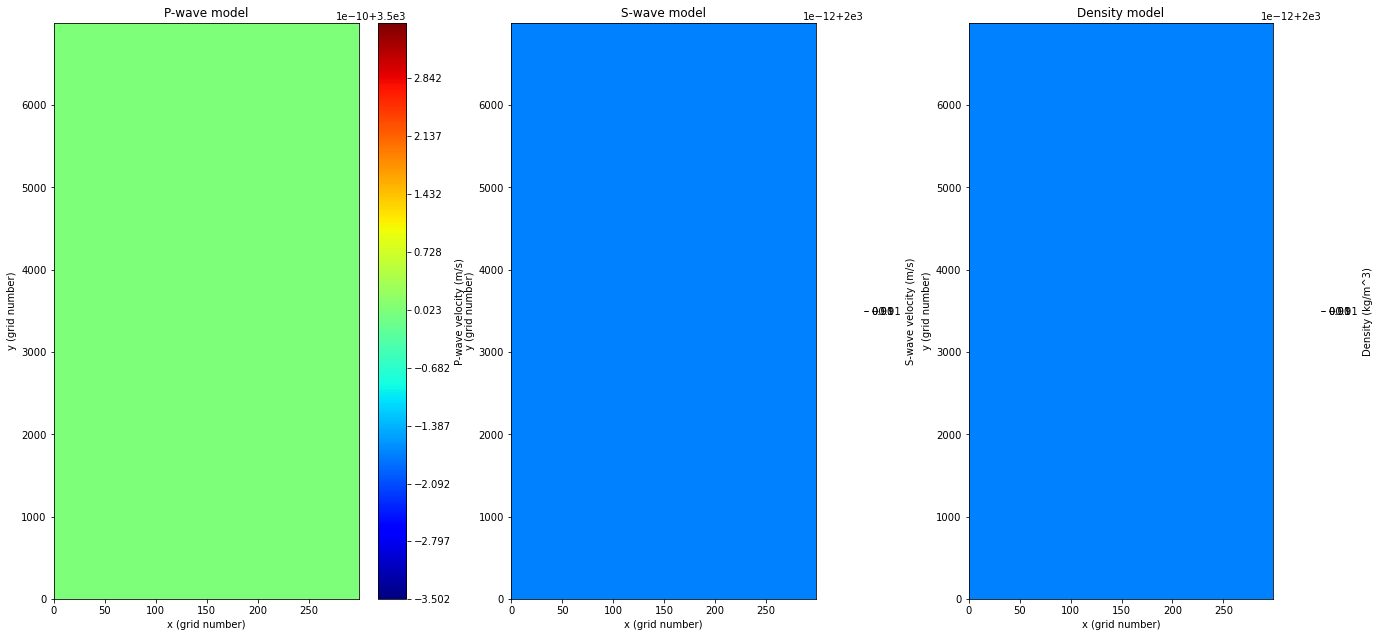

In [15]:
#Base layer
#Define parameters:
#P-wave velocity (m/s)
Vp=3500
#S-wave velocity (m/s)
Vs=2000
#Density (kg/m^3)
Rho=2000
#Vp-wave attenuation (unitless)
Qp=0
#Vs-wave attenuation (unitless)
Qs=0

#Grid generation and population
xx_grid, yy_grid = np.meshgrid(np.linspace(0,NX-1,NX),np.linspace(0,NY-1,NY))
zz_Vp=np.ones([NX,NY])*Vp
zz_Vs=np.ones([NX,NY])*Vs
zz_Rho=np.ones([NX,NY])*Rho
if L>0:
    zz_Qp=np.ones([NX,NY])*Qp
    zz_Qs=np.ones([NX,NY])*Qs
if L==0:
    plotmodels_elastic(xx_grid.T,yy_grid.T,zz_Vp,zz_Vs,zz_Rho)
else:
    plotmodels_visco(xx_grid.T,yy_grid.T,zz_Vp,zz_Vs,zz_Rho,zz_Qp,zz_Qs)

Time to add layers \
For every layer is added, the code below can be edited/copied/pasted.

In [16]:
# # Cement
# From=0
# To=0.13795
# Vp=2300
# Vs=1000
# Rho=2000
# Qp=0.01
# Qs=0.01
# [zz_Vp,zz_Vs,zz_Rho] = Placement_VerticallLayer_Elastic(zz_Vp,zz_Vs,zz_Rho,NX,NY,DH,From,To,Vp,Vs,Rho)

# # Casing
# From=0
# To=0.11795
# Vp=5860
# Vs=3130
# Rho=7800
# Qp=0.01
# Qs=0.01
# [zz_Vp,zz_Vs,zz_Rho] = Placement_VerticallLayer_Elastic(zz_Vp,zz_Vs,zz_Rho,NX,NY,DH,From,To,Vp,Vs,Rho)

# Borehole
From=0
To=0.10795
Vp=1524
Vs=0
Rho=1100
Qp=0.01
Qs=0.01
[zz_Vp,zz_Vs,zz_Rho] = Placement_VerticallLayer_Elastic(zz_Vp,zz_Vs,zz_Rho,NX,NY,DH,From,To,Vp,Vs,Rho)

# # Tool
# From=0
# To=0.046
# Vp=1650
# Vs=400
# Rho=4451.7
# Qp=0.2
# Qs=1
# [zz_Vp,zz_Vs,zz_Rho] = Placement_VerticallLayer_Elastic(zz_Vp,zz_Vs,zz_Rho,NX,NY,DH,From,To,Vp,Vs,Rho)

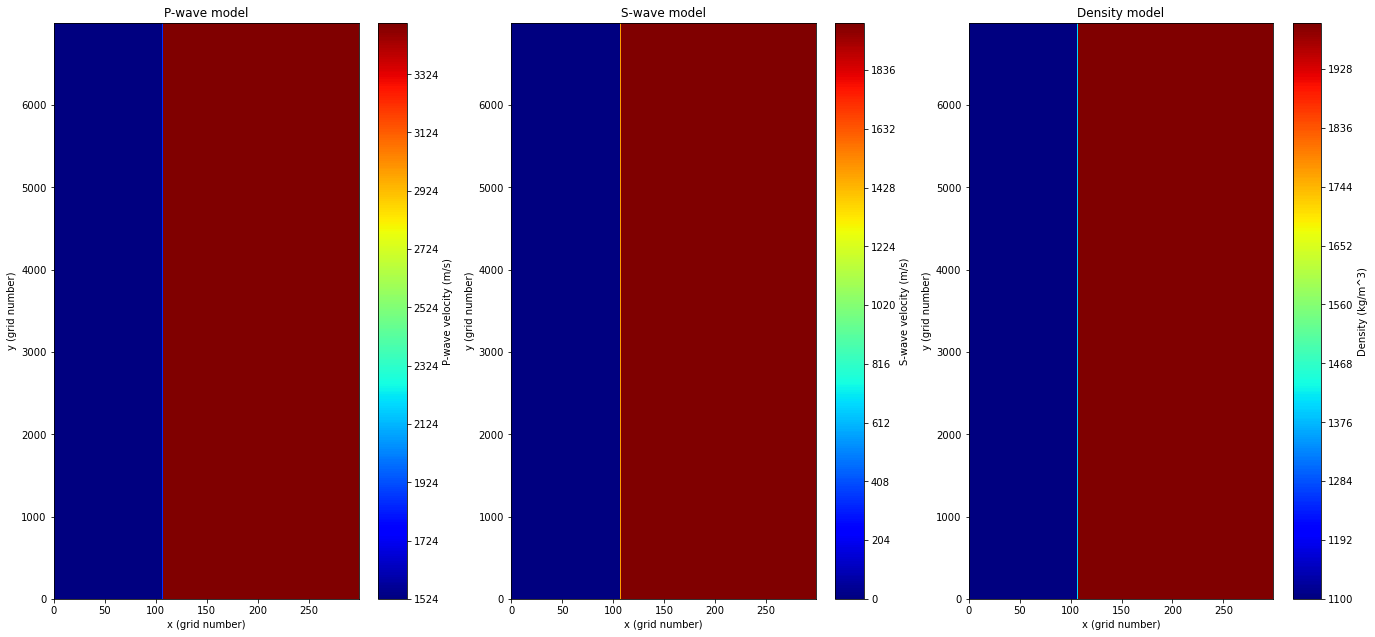

In [17]:
if L==0:
    plotmodels_elastic(xx_grid.T,yy_grid.T,zz_Vp,zz_Vs,zz_Rho)
else:
    plotmodels_visco(xx_grid.T,yy_grid.T,zz_Vp,zz_Vs,zz_Rho,zz_Qp,zz_Qs)

### 3. Exporting the models
Each model is imported as a different file with extension .vp, .vs, .rho, .qp, and .qs for P-wave velocity, S-wave velocity, Density, P-wave attenuation, and S-wave attenuation, respectively

In [18]:
os.chdir("C:/Users/Gabinni/Documents/SOFI2D/Main Version - 2016 Release/models") 

In [19]:
savefile_fromfloat32arraytobinary('test.vp',NX,NY,zz_Vp.astype('float32'))
savefile_fromfloat32arraytobinary('test.vs',NX,NY,zz_Vs.astype('float32'))
savefile_fromfloat32arraytobinary('test.rho',NX,NY,zz_Rho.astype('float32'))
if L>0:
    savefile_fromfloat32arraytobinary('test.qp',NX,NY,zz_Qp.astype('float32'))
    savefile_fromfloat32arraytobinary('test.qs',NX,NY,zz_Qs.astype('float32'))

### 4. Designing of JSON parameter file
Along this section I interactively set up json file parameters, as described in the SOFI2D guide.

#### 4.1 Domain

SOFI2D allows for multiprocessor processing by dividing the domain into subgrids.
The total number of processors must be specified when starting the program, defining NP:

mpirun - np <NP> ../bin/sofi2D < sofi2D.json
                                            
Parameters are:
- NPROCX : number of processors in x-direction
- NPROCY : number of processors in y-direction

If the total number of processors in sofi2D.json (calculated as NPROCX*NPROCY) and the command line differ the program will terminate with an error message

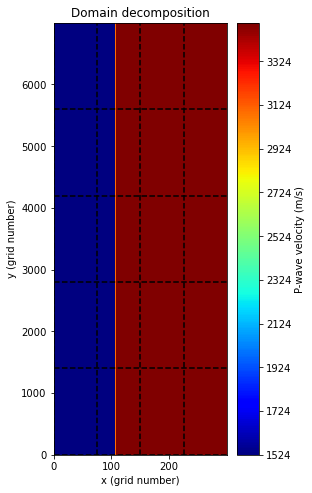

In [20]:
NPROCX=4
NPROCY=5

stepx=NX/NPROCX
stepy=NY/NPROCY

im1 = plt.contourf(xx_grid.T, yy_grid.T, zz_Vp,500,cmap=plt.cm.jet,norm=None)
plt.title('Domain decomposition')
plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
cbar = plt.colorbar(im1, orientation = 'vertical')
cbar.set_label("P-wave velocity (m/s)")
for n in range(NPROCX):
    plt.plot([n*stepx,n*stepx],[0,NY-1],'black',linestyle='dashed')
for m in range(NPROCY):
    plt.plot([0,NX-1],[m*stepy,m*stepy],'black',linestyle='dashed')

plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5, top=1.5, wspace=0.2, hspace=0.2)

#### Parameter QC
NX/NPROCX and NY/NPROCY should be integers.

In [21]:
print('NX/NPROCX: '+str(stepx))
print('NY/NPROCY: '+str(stepy))
print('If NX/NPROCX or NY/NPROCY are not integer, these are available prime factors for NX and NY to define NPROX, NPROXY:')
print('Prime factors for NX: '+ str(sympy.primefactors(NX)))
print('Prime factors for NY: '+ str(sympy.primefactors(NY)))

NX/NPROCX: 75.0
NY/NPROCY: 1400.0
If NX/NPROCX or NY/NPROCY are not integer, these are available prime factors for NX and NY to define NPROX, NPROXY:
Prime factors for NX: [2, 3, 5]
Prime factors for NY: [2, 5, 7]


##### JSON File

In [22]:
jsonfile_output={"Domain Decomposition":"comment"}
jsonfile_output["NPROCX"]=str(NPROCX)
jsonfile_output["NPROCY"]=str(NPROCY)

#### 4.2 Order of the FD Operator
In this step I define the order of the FD operator.
This section is related to section 1., where I defined the grid based on Taylor and Holberg operators.
Parameters are:
- FDORDER:Order of ssg FD coefficients (values: 2, 4, ..., 12)
- FDORDER_TIME: Order of temporal FD coefficients (values: 2 and 4)
- MAXRELERROR: Maximum relative group velocity error E and minimum number of grid points per shortest wavelengths where:
      - 0 --> Taylor coefficients
      - 1 --> Holberg coefficients
      - E=0.5%
      - E=1.0%
      - E=3.0%

In [23]:
# Previous values
print('Preliminary values MAXRELERROR: = '+str(FDmodel)+' ('+str(Model_list[FDmodel])+')')
print('Preliminary FDORDER = '+str(FD_order))
print('Preliminary FDORDER_TIME = '+str(FD_ordertime))

Preliminary values MAXRELERROR: = 1 (Holberg01)
Preliminary FDORDER = 12
Preliminary FDORDER_TIME = 4


In [24]:
FDORDER=FD_order
FDORDER_TIME=FD_ordertime
MAXRELERROR=FDmodel

##### JSON File Update

In [25]:
jsonfile_output["FD order"]="comment"
jsonfile_output["FDORDER"]=str(FDORDER)
jsonfile_output["FDORDER_TIME"]=str(FDORDER_TIME)
jsonfile_output["MAXRELERROR"]=str(MAXRELERROR)

#### 4.3 Discretization
This step import parameters from sections 1 and 2 and checks stability.
Outputs are the initial parameters we defined first:
- NX: number of grid points in the x-direction
- NY: number of grid points in the y-direction
- DH: distance between grid points

I repeat the same stability check than the one performed by the code.

In [26]:
print('Grid has the following dimensions. X:'+str(np.round(NX))+',Y:'+str(np.round(NY))+' with a grid distance '+str(np.round(DH)))
vmin=ModelMinVel
fc=CenterFrequency
N=FD_order
dh_min=vmin/(2*fc*N)
print('Minimum grid size required for stability: '+str(dh_min)+' vs '+str(DH))

Grid has the following dimensions. X:300,Y:7000 with a grid distance 0.0
Minimum grid size required for stability: 0.015875 vs 0.001


##### JSON Update

In [27]:
jsonfile_output["2-D Grid"]="comment"
jsonfile_output["NX"]=str(NX)
jsonfile_output["NY"]=str(NY)
jsonfile_output["DH"]=str(DH)

#### 4.4 Time stepping
This step I double check that my time stepping is compliant with the minimum value \
Parameters are:
- TIME: Experiment time
- DT: Time stepping interval

In [28]:
h_value=DH
vmax=ModelMaxVel
dt_min=DH/(h_value*np.sqrt(2)*vmax)
print('Minimum step size required for stability: '+str(dt_min)+' vs '+str(DT))

Minimum step size required for stability: 0.00020203050891044212 vs 2.5e-08


##### JSON Update

In [29]:
jsonfile_output["Time Stepping"]="comment"
jsonfile_output["TIME"]=str(TIME)
jsonfile_output["DT"]=str(DT)

#### 4.5 Source
In this section I define the shape, source type and location of sources.
Parameters are:
- SOURCE_SHAPE: Shape of source signal (Ricker=1, Fumue=2, using SIGNAL_FILE=3, sinus^3=4)
- SOURCE_TYPE: Point source (explosive=1, force in x=2, force in y=3)
- PLANE_WAVE_DEPTH: Depth of plane wave excitation in meters (if no=0)
- PLANE_WAVE_ANGLE: Dip of plane wave from vertical (in deg)
- TS: Duration of source signal
- SIGNAL_FILE: External signal file name
- SRCREC: Read source positions from external SOURCE_FILE (yes=1)
- SOURCE_FILE: File with source locations
- RUN_MULTIPLE_SHOTS: Multiple shots modeled simultaneously (0) or individually (1)

I subdivide this interval into Source Shape and Source Type/Location sections

##### Source Shape
Along this section I define the source shape. In case I use a plane wave, then SOURCE_SHAPE applies to the experiment, otherwise it is defined for each source in the source file.


40000
2.5e-08 2.5e-08


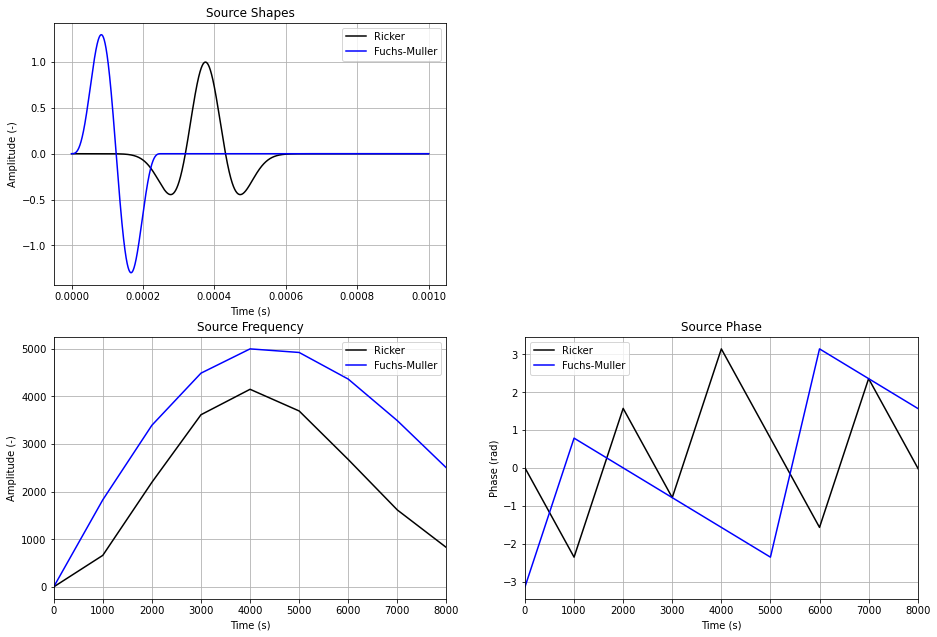

In [30]:
#Source shapes
TS=1/1000                #Duration of source signal (s)
FC=CenterFrequency                #Central frequency (Hz)
TD=0/1000                #Time delay (s)
#Defining the time vector
t=np.arange(0,TS,DT)
DT=DT
# t=np.linspace(0,(2**8-1)*DT,2**8)
print(len(t))
print(DT,(t[1]-t[0]))
#Ricker wavelet
tau=np.pi*(t-1.5/FC-TD)/(1/FC)
r=(1-2*tau**2)*np.exp(-tau**2)
#Fuchs-Muller wavelet
fm=np.zeros(len(t))
scube=np.zeros(len(t))
for n in range(len(t)):
    if n*DT>=TD and n*DT<=TD+1/FC:
        fm[n]=np.sin(2*np.pi*(n*DT-TD)*FC)-0.5*np.sin(4*np.pi*(n*DT-TD)*FC)
    else:
        fm[n]=0
#Sin^3 wavelet
for n in range(len(t)):
    if n*DT>=TD and n*DT<=TD+1/FC:
        scube[n]=0.00005*np.pi*FC*(np.sin(np.pi*(n*DT-TD)*FC))**3
    else:
        scube[n]=0

f_x=fftshift(fftfreq(len(t),d=DT))
fft_r=fftshift(fft(r))
f_r_amp=np.abs(fft_r)
f_r_phase=np.angle(fft_r)
fft_fm=fftshift(fft(fm))
f_fm_amp=np.abs(fft_fm)
f_fm_phase=np.angle(fft_fm)
fft_scube=fftshift(fft(scube))
f_scube_amp=np.abs(fft_scube)
f_scube_phase=np.angle(fft_scube)

plt.subplot(221)
plt.plot(t,r,'black',label='Ricker')
plt.plot(t,fm,'blue',label='Fuchs-Muller')
# plt.plot(t,scube,'red',label='Sin^3')
plt.legend(); plt.grid()
plt.title('Source Shapes')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude (-)')
plt.subplot(223)
plt.plot(f_x,f_r_amp,'black',label='Ricker')
plt.plot(f_x,f_fm_amp,'blue',label='Fuchs-Muller')
# plt.plot(f_x,f_scube_amp,'red',label='Sin^3')
plt.legend(); plt.grid()
plt.title('Source Frequency')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude (-)')
plt.xlim(0,MaxFrequency)
plt.subplot(224)
plt.plot(f_x,f_r_phase,'black',label='Ricker')
plt.plot(f_x,f_fm_phase,'blue',label='Fuchs-Muller')
# plt.plot(f_x,f_scube_phase,'red',label='Sin^3')
plt.legend(); plt.grid()
plt.title('Source Phase')
plt.xlabel('Time (s)'); plt.ylabel('Phase (rad)')
plt.xlim(0,MaxFrequency)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=2, wspace=0.2, hspace=0.2)

In [31]:
SOURCE_SHAPE=1
SIGNAL_FILE='signal_mseis.tz'
SRCREC=1
SOURCE_FILE='./sources/source.dat'
RUN_MULTIPLE_SHOTS=0

##### Source Type/Location
###### Plane wave

Plane waves are generated from a line source defined all along the domain.
In case a plane wave is used, the following parameters are required:
- PLANE_WAVE_DEPTH: Depth of plane wave excitation in meters (if no=0)
- PLANE_WAVE_ANGLE: Dip of plane wave from vertical (in deg)
Also, we recommend to set this parameter:
- SRCREC: Read source positions from external SOURCE_FILE (no=0)

The following code allows to interactively see the location and propagation direction of the plane wave

In [32]:
PLANE_WAVE_DEPTH=0                       #in m
PLANE_WAVE_ANGLE=89                       #in deg
TS=0.2
if PLANE_WAVE_DEPTH==0:
    print('No Plane Waveform')
else:
    #The line source is defined as a slope y=a+bx where a=PLANE_WAVE_DEPTH and b=tan(PLANE_WAVE_ANGLE)
    x_bottom=(Y_length-PLANE_WAVE_DEPTH)/np.tan(PLANE_WAVE_ANGLE*np.pi/180)

    plt.subplot(1,2,1)
    im1 = plt.contourf(xx_grid, yy_grid, zz_Vp,500,cmap=plt.cm.jet,norm=None)
    plt.plot([0,int(np.round(x_bottom/dh_model))],[int(np.round(PLANE_WAVE_DEPTH/dh_model)),int(np.round(Y_length/dh_model))],'red',label='Plane wave source')
    plt.xlim(0,NX-1) ; plt.ylim(0,NY-1)
    plt.legend()
    plt.title('Plane wave - Line')
    plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
    cbar = plt.colorbar(im1, orientation = 'vertical')
    cbar.set_label("P-wave velocity (m/s)")

    y_source=np.linspace(0,NY-1,NY-1)
    x_source=np.linspace(0,NY-1,NY-1)
    for n in range(NY-1):
        x_source[n]=int(np.round((NY-int(np.round(PLANE_WAVE_DEPTH/dh_model)))/np.tan(PLANE_WAVE_ANGLE*np.pi/180)/dh_model))
    plt.subplot(1,2,2)
    im1 = plt.contourf(xx_grid, yy_grid, zz_Vp,500,cmap=plt.cm.jet,norm=None)
    plt.scatter(x_source,y_source, color='black',label='Source Location')
    plt.xlim(0,NX-1) ; plt.ylim(0,NY-1)
    plt.legend()
    plt.title('Plane wave - Grid')
    plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
    cbar = plt.colorbar(im1, orientation = 'vertical')
    cbar.set_label("P-wave velocity (m/s)")

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1, wspace=0.2, hspace=0.2)

No Plane Waveform


<Figure size 432x288 with 0 Axes>

##### Point sources
In this section I generate a single set of point sources defined from a line vector.
This definition requires the generation of an ASCII file (SOURCE_FILE). In the JSON file, the following parameters are required:
- PLANE_WAVE_DEPTH: 0 (Recommended)
- SRCREC: 1
- SOURCE_FILE: './sources/source.dat'

SOURCE_FILE parameters are:
- XSRC: x-coordinate of a source point (in m)
- YSRC: y-coordinate of a source point (in m)
- TD: excitation time-delay for the source point (in s)
- FC: center frequency of the source signal (in Hz)
- AMP: maximum amplitude of the source signal
- SOURCE_AZIMUTH (Optional): angle between y- and x- direction (activated if SOURCE_TYPE=4)
- SOURCE_TYPE (Optional): source type (explosive=1, force in x=2, force in y=3, SOURCE_AZIMUTH=4). If this value is set, SOURCE_TYPE in here overrides SOURCE_TYPE from the JSON file




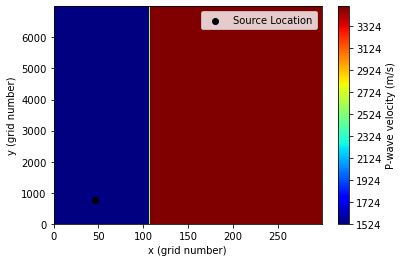

In [33]:
#Define coordinates for source
SourceFileinput=np.zeros([0,7])
#Source set 1
x_start=0.046
x_end=0.046
y_start=0.75
y_end=0.75
spacing=DH/10
TD=0/10000
FC=FC
AMP=1
SOURCE_AZIMUTH=0
SOURCE_TYPE=1

Array_raw=LinearArray(x_start,x_end,y_start,y_end,spacing)
Array=TRplacement(DH,0,0,Array_raw)
Source_addon=np.zeros([len(Array),7])
for n in range(len(Array)):
    Source_addon[n,0]=Array[n,0]
    Source_addon[n,1]=Array[n,1]
    Source_addon[n,2]=TD
    Source_addon[n,3]=FC
    Source_addon[n,4]=AMP
    Source_addon[n,5]=SOURCE_AZIMUTH
    Source_addon[n,6]=SOURCE_TYPE
SourceFileinput=np.vstack((SourceFileinput,Source_addon))

im1 = plt.contourf(xx_grid.T, yy_grid.T, zz_Vp,500,cmap=plt.cm.jet,norm=None)
plt.scatter(SourceFileinput[:,0]/DH,SourceFileinput[:,1]/DH, color='black',label='Source Location')
plt.xlim(0,NX-1) ; plt.ylim(0,NY-1)
plt.legend()
plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
cbar = plt.colorbar(im1, orientation = 'vertical')
cbar.set_label("P-wave velocity (m/s)")

##### Writing SOURCEFILE

In [34]:
Decimals=6
file=open('source.dat','w')
for n in range(len(SourceFileinput)):
    file.write('{} {} {} {} {} {} {}\n'.format(np.round(SourceFileinput[n,0],decimals=Decimals),np.round(SourceFileinput[n,1],decimals=Decimals),np.round(SourceFileinput[n,2],decimals=Decimals),np.round(SourceFileinput[n,3],decimals=Decimals),np.round(SourceFileinput[n,4],decimals=Decimals),np.round(SourceFileinput[n,5],decimals=Decimals),np.round(SourceFileinput[n,6],decimals=Decimals)))
file.close()

In [35]:
file=open('source.dat','r')
print(file.read())

0.046 0.75 0.0 4000.0 1.0 0.0 1.0



##### JSON Update

In [36]:
jsonfile_output["Sources"]="comment"
jsonfile_output["SOURCE_SHAPE"]=str(SOURCE_SHAPE)
jsonfile_output["SIGNAL_FILE"]=str(SIGNAL_FILE)
jsonfile_output["SOURCE_TYPE"]=str(SOURCE_TYPE)
jsonfile_output["SRCREC"]=str(SRCREC)
jsonfile_output["SOURCE_FILE"]=str(SOURCE_FILE)
jsonfile_output["RUN_MULTIPLE_SHOTS"]=str(RUN_MULTIPLE_SHOTS)
jsonfile_output["PLANE_WAVE_DEPTH"]=str(PLANE_WAVE_DEPTH)
jsonfile_output["PLANE_WAVE_ANGLE"]=str(PLANE_WAVE_ANGLE)
jsonfile_output["TS"]=str(TS)

#### 4.6 Generation of models
In this section I choose the input models. In case I use the models designed before in Section 2, then READMOD=1
Parameters are:
- READMOD: read model parameter from MFILE (Yes=1)
- MFILE: String for model file names
- WRITE_MODELS: Switch to decide if models are written to file (No model=0, all models=1, only density=2)

In [37]:
READMOD=1
MFILE='model/test'
WRITE_MODELFILES=0

##### JSON Update

In [38]:
jsonfile_output["Model Generation"]="comment"
jsonfile_output["READMOD"]=str(READMOD)
jsonfile_output["MFILE"]=str(MFILE)
jsonfile_output["WRITE_MODELFILES"]=str(WRITE_MODELFILES)

#### 4.7 Q-approximation
This section is to choose whether the model behaves as an elastic or viscoelastic model.
Parameters are:
- L: Number of relaxation mechanisms (elastic=0, >0 viscoelastic)
- FLn: Relaxation frequency (one for each relaxation mechanism)
- TAU: T-> check Bohlen 2002

In [39]:
L=0
FL1=5
TAU=0.00001

##### JSON Update

In [40]:
jsonfile_output["Q-Approximation"]="comment"
jsonfile_output["L"]=str(L)
jsonfile_output["FL1"]=str(FL1)
jsonfile_output["TAU"]=str(TAU)

#### 4.8 Boundary conditions
In this section I update the set up for boundary conditions. There are two options: CPML-Boundary and Damping-Boundary, each one with its own set of parameters.
Parameters are:
- FREE-SURF: free surface at the top of the model (Yes=1)
- BOUNDARY: apply periodic boundary condition at edges (no=0, left and right=1)
- FW: width of absorbing frame (in gridpoints, no=0)
- ABS_TYPE: Type of absorbing boundary (CPML-Boundary=1, Damping-Boundary=2)
For CPML-Boundary (ABS_TYPE=1) --> recommended width: 10-20 grid points
- NPOWER: Check references
- K_MAX_CPML: Check references
- VPPML: approximately propagation velocity near borders
- FPML: aproximately dominant frequency at borders
For Damping-Boundary (ABS_TYPE=2) --> recommended width: >20 grid points
- DAMPING: percentual factor per grid

In [41]:
FREE_SURF=0
BOUNDARY=0
FW=15
ABS_TYPE=1
NPOWER= 4
K_MAX_CPML=1
VPPML=3500
FPML=4000
DAMPING=8

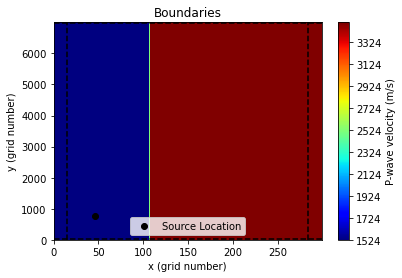

In [42]:
im1 = plt.contourf(xx_grid.T, yy_grid.T, zz_Vp,500,cmap=plt.cm.jet,norm=None)
plt.scatter(SourceFileinput[:,0]/DH,SourceFileinput[:,1]/DH, color='black',label='Source Location')
plt.plot([0,NX-1],[FW,FW],'black',linestyle='dashed')
plt.plot([0,NX-1],[NY-FW-1,NY-FW-1],'black',linestyle='dashed')
plt.plot([FW,FW],[0,NY-1],'black',linestyle='dashed')
plt.plot([NX-FW-1,NX-FW-1],[0,NY-1],'black',linestyle='dashed')
plt.xlim(0,NX-1) ; plt.ylim(0,NY-1)
plt.legend()
plt.title('Boundaries')
plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
cbar = plt.colorbar(im1, orientation = 'vertical')
cbar.set_label("P-wave velocity (m/s)")

In [43]:
print('QC for NX/NPROCX and NY/NPROCY values. FW should be smaller than these values')
print('FW: '+str(FW))
print('NX/NPROCX: '+str(stepx))
print('NY/NPROCY: '+str(stepy))

QC for NX/NPROCX and NY/NPROCY values. FW should be smaller than these values
FW: 15
NX/NPROCX: 75.0
NY/NPROCY: 1400.0


##### JSON Update

In [44]:
jsonfile_output["Boundary Conditions"]="comment"
jsonfile_output["FREE_SURF"]=str(FREE_SURF)
jsonfile_output["BOUNDARY"]=str(BOUNDARY)
jsonfile_output["FW"]=str(FW)
jsonfile_output["ABS_TYPE"]=str(ABS_TYPE)
jsonfile_output["NPOWER"]=str(NPOWER)
jsonfile_output["K_MAX_CPML"]=str(K_MAX_CPML)
jsonfile_output["VPPML"]=str(VPPML)
jsonfile_output["FPML"]=str(FPML)
jsonfile_output["DAMPING"]=str(DAMPING)

#### 4.9 Wavefield snapshots
In this section I set up what snapshots I want.
Parameters are:
- SNAP: Output type (no seismograms=0, particle-velocities=1, pressure field=2, curl and divergence energy=3, velocities, pressure and energy=4)
- TSNAP: first snapshot (in s)
- TSNAP: last snapshot (in s)
- TSNAPINC: increment (in s)
- IDX: increment x-direction (in grid points) -> higher values smaller resolution
- IDY: increment y-direction (in grid points) -> higher values smaller resolution
- SNAP_FORMA: data format (ASCII=2, BINARY=3)
- SNAP_FILE: snap filename

In [45]:
SNAP=4
TSNAP1=DT
TSNAP2=TIME
TSNAPINC=TIME/10
IDX=1
IDY=1
SNAP_FORMAT=3
SNAP_FILE='./snap/test'

In [46]:
print('QC for IDX and IDY values. NX/NPROCX/IDX and NY/NPROCY/IDY should be integers')
print('NX/NPROCX/IDX: '+str(stepx/IDX))
print('NY/NPROCY/IDY: '+str(stepy/IDY))
print('Prime factors for NX: '+ str(sympy.primefactors(stepx)))
print('Prime factors for NY: '+ str(sympy.primefactors(stepy)))

QC for IDX and IDY values. NX/NPROCX/IDX and NY/NPROCY/IDY should be integers
NX/NPROCX/IDX: 75.0
NY/NPROCY/IDY: 1400.0
Prime factors for NX: [3, 5]
Prime factors for NY: [2, 5, 7]


##### JSON Update

In [47]:
jsonfile_output["Wavefield Snapshots"]="comment"
jsonfile_output["SNAP"]=str(SNAP)
jsonfile_output["TSNAP1"]=str(TSNAP1)
jsonfile_output["TSNAP2"]=str(TSNAP2)
jsonfile_output["TSNAPINC"]=str(TSNAPINC)
jsonfile_output["IDX"]=str(IDX)
jsonfile_output["IDY"]=str(IDY)
jsonfile_output["SNAP_FORMAT"]=str(SNAP_FORMAT)
jsonfile_output["SNAP_FILE"]=str(SNAP_FILE)

#### 4.10 Receivers
I design the receivers set as an array of receivers. If I want to a 'single receiver', I put a continuous line of receivers placed from a start to an end. If I want multiple receivers, I used the x and y start points for the first receivers and then I add another receiver at a specific distance.
Parameters are:
- SEISMO: output of seismograms (no seismograms=0, particle-velocities=1, pressure (hydrphone)=2, curl and dive=3, everything= 4)
- READREC: Read receiver positions from file (Yes=1). If Yes, then XREC1, YREC1, XREC2, YREC2, and NGEOPH are ignored
- REC_FILE: External receiver file name
- REFREC: Reference point for receiver coordinate system
- XREC1, YREC1: position of first receiver (in m)
- XREC2, YREC2: position of last receiver (in m)
- NGEOPH: distance between two adjacent receivers (in gridpoints)

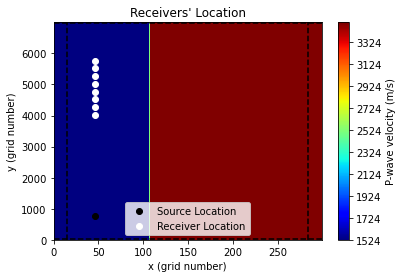

In [48]:
#Define coordinates for source
ReceiverFileinput=np.zeros([0,2])
#Receiver set 1
x_start=0.046
x_end=0.046
y_start=4.0266
y_end=6.01

ReqReceivers=8
DistStarttoEnd=np.sqrt((x_end-x_start)**2+(y_end-y_start)**2)
DistReceivers_m=DistStarttoEnd/ReqReceivers

spacing=DistReceivers_m

Array_raw=LinearArray(x_start,x_end,y_start,y_end,spacing)
Array=TRplacement(DH,0,0,Array_raw)
Receiver_addon=np.zeros([len(Array),2])
for n in range(len(Array)):
    Receiver_addon[n,0]=Array[n,0]
    Receiver_addon[n,1]=Array[n,1]
ReceiverFileinput=np.vstack((ReceiverFileinput,Receiver_addon))

im1 = plt.contourf(xx_grid.T, yy_grid.T, zz_Vp,500,cmap=plt.cm.jet,norm=None)
plt.scatter(SourceFileinput[:,0]/DH,SourceFileinput[:,1]/DH, color='black',label='Source Location')
plt.scatter(ReceiverFileinput[:,0]/DH,ReceiverFileinput[:,1]/DH, color='white',label='Receiver Location')
plt.plot([0,NX-1],[FW,FW],'black',linestyle='dashed')
plt.plot([0,NX-1],[NY-FW-1,NY-FW-1],'black',linestyle='dashed')
plt.plot([FW,FW],[0,NY-1],'black',linestyle='dashed')
plt.plot([NX-FW-1,NX-FW-1],[0,NY-1],'black',linestyle='dashed')
plt.xlim(0,NX-1) ; plt.ylim(0,NY-1)
plt.legend()
plt.title("Receivers' Location")
plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
cbar = plt.colorbar(im1, orientation = 'vertical')
cbar.set_label("P-wave velocity (m/s)")

In [49]:
SEISMO=4
READREC=0
REC_FILE='./receiver/receiver.dat'
REFREC_TUPLE=str(0)+' , '+str(0)
REC1_TUPLE=str(x_start)+' , '+str(y_start)
REC2_TUPLE=str(x_end)+' , '+str(y_end)
NGEOPH=1

In [50]:
Decimals=6
file=open('receiver.dat','w')
for n in range(len(ReceiverFileinput)):
    file.write('{} {}\n'.format(np.round(ReceiverFileinput[n,0],decimals=Decimals),np.round(ReceiverFileinput[n,1],decimals=Decimals)))
file.close()

In [51]:
file=open('receiver.dat','r')
print(file.read())

0.046 4.026
0.046 4.274
0.046 4.522
0.046 4.77
0.046 5.018
0.046 5.266
0.046 5.514
0.046 5.762



##### JSON Update

In [52]:
jsonfile_output["Receivers"]="comment"
jsonfile_output["SEISMO"]=str(SEISMO)
jsonfile_output["READREC"]=str(READREC)
jsonfile_output["REC_FILE"]=str(REC_FILE)
jsonfile_output["REFRECX, REFRECY"]=str(REFREC_TUPLE)
jsonfile_output["XREC1, YREC1"]=str(REC1_TUPLE)
jsonfile_output["XREC2, YREC2"]=str(REC2_TUPLE)
jsonfile_output["NGEOPH"]=str(NGEOPH)

#### 4.11 Receiver array
In case I want horizontal set of receivers, I can set up this option on.
Parameters are:
- REC_ARRAY: number of horizontal receiver arrays simulated. (No=0)
- REC_ARRAY_DEPTH: depth of the first array (in m)
- REC_ARRAY_DIST: vertical distance between arrays (in m)
- DRX: distance between receivers for each horizontal array (in grid points)

In [53]:
REC_ARRAY=0
REC_ARRAY_DEPTH=70
REC_ARRAY_DIST=40
DRX=4

##### JSON Update

In [54]:
jsonfile_output["Receivers array"]="comment"
jsonfile_output["REC_ARRAY"]=str(REC_ARRAY)
jsonfile_output["REC_ARRAY_DEPTH"]=str(REC_ARRAY_DEPTH)
jsonfile_output["REC_ARRAY_DIST"]=str(REC_ARRAY_DIST)
jsonfile_output["DRX"]=str(DRX)

#### 4.12 Seismograms
In this step, I set up the format and location of output waveforms at each receiver.
Parameters are:
- NDT: sampling rate (in time steps)
- SEIS_FORMAT: data output format (SU format=1, TEXTUAL -native ASCII- =2,BINARY -IEEE-4-bytes-float-=3)
- SEIS_FILE: basic filename

In [55]:
NDT=1
SEIS_FORMAT=4
SEIS_FILE='./su/test'

##### JSON Update

In [56]:
jsonfile_output["Seismograms"]="comment"
jsonfile_output["NDT"]=str(NDT)
jsonfile_output["SEIS_FORMAT"]=str(SEIS_FORMAT)
jsonfile_output["SEIS_FILE"]=str(SEIS_FILE)

#### 4.13 Monitoring the simulation
In this step I setup the amount of information I obtain in order to control the simulation.
Parameters are:
- LOG: output of logging information of node (no output=0, to stdout=1, to file LOG_FILE=2)
- LOG_FILE: log file name to output the monitoring info
- OUT_TIMESTEP_INFO: time between monitoring outputs

In [57]:
LOG=1
LOG_FILE='log/test.log/'
OUT_TIMESTEP_INFO=10000

##### JSON Update

In [58]:
jsonfile_output["Monitoring"]="comment"
jsonfile_output["LOG_FILE"]=str(LOG_FILE)
jsonfile_output["LOG"]=str(LOG)
jsonfile_output["OUT_TIMESTEP_INFO"]=str(OUT_TIMESTEP_INFO)

#### 4.14 Checkpointing (probably not working on the code...)
If I want to generate checkpoints and continue from an specific point since I interrupted my processing, I can set up this parameters. They can generate a huge amount of data!
Parameters are:
- CHECKPTREAD: read wavefield from checkpoint file (yes=1, no=0)
- CHECKPTWRITE: write wavefield to checkpoint file (yes=1, no=0)
- CHECKPTFILE: checkpoint filename

In [59]:
CHECKPTREAD=0
CHECKPTWRITE=0
CHECKPT_FILE='tmp/checkpoint_sofi2D'

##### JSON Update

In [60]:
jsonfile_output["Checkpointing"]="comment"
jsonfile_output["CHECKPTREAD"]=str(CHECKPTREAD)
jsonfile_output["CHECKPTWRITE"]=str(CHECKPTWRITE)
jsonfile_output["CHECKPT_FILE"]=str(CHECKPT_FILE)

#### 4.15 JSON File Preview

In [61]:
with open('sofi2D.json', 'w+') as f:
    json.dump(jsonfile_output, f,indent=0)

In [62]:
jsonfile = open("sofi2D.json", "r")
print(jsonfile.read())
jsonfile.close()

{
"Domain Decomposition": "comment",
"NPROCX": "4",
"NPROCY": "5",
"FD order": "comment",
"FDORDER": "12",
"FDORDER_TIME": "4",
"MAXRELERROR": "1",
"2-D Grid": "comment",
"NX": "300",
"NY": "7000",
"DH": "0.001",
"Time Stepping": "comment",
"TIME": "0.0055",
"DT": "2.5e-08",
"Sources": "comment",
"SOURCE_SHAPE": "1",
"SIGNAL_FILE": "signal_mseis.tz",
"SOURCE_TYPE": "1",
"SRCREC": "1",
"SOURCE_FILE": "./sources/source.dat",
"RUN_MULTIPLE_SHOTS": "0",
"PLANE_WAVE_DEPTH": "0",
"PLANE_WAVE_ANGLE": "89",
"TS": "0.2",
"Model Generation": "comment",
"READMOD": "1",
"MFILE": "model/test",
"WRITE_MODELFILES": "0",
"Q-Approximation": "comment",
"L": "0",
"FL1": "5",
"TAU": "1e-05",
"Boundary Conditions": "comment",
"FREE_SURF": "0",
"BOUNDARY": "0",
"FW": "15",
"ABS_TYPE": "1",
"NPOWER": "4",
"K_MAX_CPML": "1",
"VPPML": "3500",
"FPML": "4000",
"DAMPING": "8",
"Wavefield Snapshots": "comment",
"SNAP": "4",
"TSNAP1": "2.5e-08",
"TSNAP2": "0.0055",
"TSNAPINC": "0.0005499999999999999",
"IDX": "1",
"

### 5. Next Steps

#### 5.1 Generated input files and location
We describe the generated files, function and location within the /SOFI2D/par/ folder
- JSON file (sofi2D.json)--> Parameters --> ./in_and_out/
- VP, VS, RHO, QP and QS models (test.vp, test.vs, test.rho, test.qp, test.qs) --> Mechanical properties models --> ./model/
- SOURCES file (source.dat) --> Sources' location and parameters --> ./sources/
- RECEIVERS file (receiver.dat) --> Receiver's location

#### 5.2 Model QC
After moving the model files to SOFI2D/model/ folder, we can check the model structure using the command ximage.
Using this command before executing the files helps QCing input files.
Execute for (each) one of the input model files (from SOFI2D/par/ directory):
ximage n1=NY n2=NX < model/.test.vp

#### 5.3 Compilation of sofi2D
This is located and run in folder SOFI2D/src/
This can be done once, unless you change something within the parametrical modeling files.
- MODEL_V=hh_visco.c --> viscoelastic model (L>0)
- MODEL_E=hh_elastic.c --> elastic model (L=0)
- Overnight builts (not developed here)
Within src directory, execute either make all or make sofi2D (snapmerge will be also generated)

#### 5.4 Running the program
Running the program is started from the folder SOFI2D/par/
Running has the following structure:
    mpirun -np 1 nice -19 ../bin/sofi2D ./in_and_out/sofi2D.json | tee ./in_and_out/sofi2D.jout
where:
- mpirun is the executing command
- -np is the number of processors we are using (if it is not equal to the one in sofi2D.json, the program will abort)
- nice -19 is the priority index (-19 allows to process sofi2D in background and using the computer while processing)
- ../bin/sofi2D is the compiled file (from 5.2)
- ./in_and_out/sofi2D.json is the parameters file
- | tee ./in_and_out/sofi2D.jout is the request to generate a report file called sofi2D.jout

Once executed, the model will show sofi2d.json parameters in a table and start working. For each parameters, it will QC whether the parameter is correct (or not) and briefly explain its implications within processing. In most cases, if a parameter is not correct (wrong input), the process will terminate and a message error will show the parameter causing the issue.

#### 5.5 Processing results - Output files and location
After execution of the script, multiple files will be generated, depending on the JSON file parameters.
We will enumerate files, structure and location of each output file:

##### 5.5.a Report File
This file writes down onscreen report shown when running the program.
It will be written if, when running the program, "| tee ./in_and_out/sofi2D.jout" was written.
Location of this file is ./in_and_out/
Format of the file is ASCII, can be opened as text

##### 5.5.b Models
These files replicate the input model we used during processing.
It will be written if the JSON parameter WRITE_MODELFILES is equal to 1 or 2. If equal to 1, then it will output all models Rho, U, Pi and Taup and Taus. If equal to 2, only density model Rho.
Location of these files is ./model/
File naming depends on the number of processors  used:
- Files start with: test.SOFI2D.property (pi, rho, u, vp, vs)
- Files have names based on how processors are distributed, assuming a grid with defined by arrays 0 to NX and 0 to NY
- For example, the Vp model used in the segment taken by Processor number 4 (in NX=NY=2) is shown as: test.SOFI2D.vp.1.1
Format of the file is binary.

##### 5.5.c Wavefield snapshots
These files replicate spatial seismograms during processing.
It will be written if the JSON parameter SNAP is equal to 1, 2, 3 or 4. If equal to 1 the output is only particle velocities; if equal to 2, is the pressure field; if 3, curl and divergence energy; and if 4, all 1,2 and 3.
Location of these files is ./snap/
File naming depends on the number of processors  used:
- Files start with: test.bin/txt.property (vx, vy, p, div, curl)
- Files have names based on how processors are distributed, assuming a grid with defined by arrays 0 to NX and 0 to NY
- For example, the Vp model used in the segment taken by Processor number 4 (in NX=NY=2) is shown as: test.bin.vp.1.1 (if the file is binary)
- A final file containing the simulation within the whole space will have no processor coordinate references
- Each file contains all snapshots in a single file
Format of the files depends on JSON parameter SNAP_FORMAT: if equal to 2, format is ASCII, if equal to 3, then binary

##### 5.5.d Seismograms
These files are the waveforms acquired by each defined receiver.
It will be written if the JSON parameter SEISMO is equal to 1, 2, 3 or 4. If equal to 1 the output is only particle velocities; if equal to 2, is the pressure field; if 3, curl and divergence energy; and if 4, all 1,2 and 3.
Location of these files is ./su/
File naming depends on the number of processors  used:
- Files start with: test_property (vx, vy, p, div, curl)
- Files have names based on how processors are distributed, assuming a grid with defined by arrays 0 to NX and 0 to NY
- For example, the Vp model used in the segment taken by Processor number 4 (in NX=NY=2) is shown as: test_vp.bin.shot1 (when analyzing shot 1 for multiple shots)
- A final file containing the simulation within the whole space will have no processor coordinate references
- If multiple shots were performed, every file will be divided for each shot
Format of the files depends on JSON parameter SEIS_FORMAT: if equal to 1, Seismic Unix format; if 2, format is ASCII, if equal to 3, then binary

